Bike sharing linear regression
---

Exercise - Load train/test sets & remove collinear features
---

> **Exercise**: Load the train/test sets into the `X_tr`, `y_tr`, `X_te` and `y_te` variables. Remove features that make the `X_tr` matrix, with the additional column of ones, rank deficient. Also, you might want to remove nearly collinear features if they hurt performance.

**Self-assessment**: Verify that the `X_tr` matrix with the additional column of ones has full rank. Compute its condition number.

In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

# Load train data
train_df = pd.read_csv("c3_bike-train.csv")
print(train_df.shape)
train_df.head()


(365, 10)


,temp,temp_C,hum,windspeed,atemp,atemp_C,yr,workingday,holiday,casual
0,0.368,9.296,0.569,0.148,0.379,9.014,1,1,0,1603
1,0.700,24.900,0.761,0.084,0.660,27.560,0,1,0,768
2,0.282,5.254,0.538,0.187,0.282,2.612,0,0,0,424
3,0.335,7.745,0.450,0.308,0.320,5.120,0,1,0,231
4,0.398,10.706,0.466,0.290,0.388,9.608,1,1,0,663


In [2]:
# Load test data
test_df = pd.read_csv("c3_bike-test.csv")
print(test_df.shape)
test_df.head()

(366, 10)


,temp,temp_C,hum,windspeed,atemp,atemp_C,yr,workingday,holiday,casual
0,0.687,24.289,0.585,0.208,0.638,26.108,0,0,0,2418
1,0.750,27.250,0.651,0.159,0.687,29.342,0,1,0,754
2,0.233,2.951,0.499,0.158,0.248,0.368,0,0,0,222
3,0.192,1.024,0.830,0.053,0.235,-0.490,0,1,0,47
4,0.342,8.074,0.770,0.073,0.356,7.496,1,1,0,244


In [4]:
# Remove collinear features
features = [
    "temp",
    "hum",
    "windspeed",
    "yr",
    "workingday",
    "holiday",
    #'atemp', # Nearly collinear column, may hurt performance
    #'temp_C', 'atemp_C' # Collinear columns
]
# Note: You could use atemp instead of temp.

# Create input matrix with the additional column of ones
X = train_df[features].values  # Train data
X1 = np.c_[np.ones(X.shape[0]), X]  # Add the column of ones

# Compute rank and condition number
M = X1.shape[1]  # Number of columns
rank = np.linalg.matrix_rank(X1)
cond = np.linalg.cond(X1)
print("Columns {} rank {} collinear {}".format(M, rank, M - rank))
print("Condition number:", cond)

Columns 7 rank 7 collinear 0
Condition number: 22.000828462946895


In [5]:
# Extract X/y Numpy variables
X_tr = train_df[features].values
y_tr = train_df.casual.values

X_te = test_df[features].values
y_te = test_df.casual.values

Exercise - Fit a linear regression model
---

> **Exercise**: (A) Fit a linear regression model to the `X_tr`, `y_tr` variables. Evaluate its performance on the test set using the mean absolute error (MAE). (B) Also, try fitting a linear regression with the Huber loss. (C) Pick one feature (e.g., temperatures) and plot the predictions from your best model (e.g., temperature vs. casual users plot).

**Note**: Your models might predict a negative number of users. In this case, you might want to set a lower limit with the Numpy `maximum()` function to improve performance, e.g. `y_pred = np.maximum(y_pred, 50)`.

In [9]:
# Compare models with mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
#(A) Linear regression
lr = LinearRegression()
lr.fit(X_tr, y_tr)  # Fit to train data
y_pred_lr = np.maximum(
    lr.predict(X_te), 50  # Predictions for test data  # Set a lower limit
)
mae_lr = MAE(y_te, y_pred_lr)
print("MAE linear regression: {:.3f}".format(mae_lr))

MAE linear regression: 279.880


In [11]:
from sklearn.linear_model import HuberRegressor

#(B) Huber loss
huber = HuberRegressor(epsilon=1.45)
huber.fit(X_tr, y_tr)  # Fit to train data
y_pred_huber = np.maximum(
    huber.predict(X_te), 50  # Predictions for test data  # set a lower limit
)
mae_huber = MAE(y_te, y_pred_huber)
print("MAE Huber: {:.3f}".format(mae_huber))

MAE Huber: 272.904


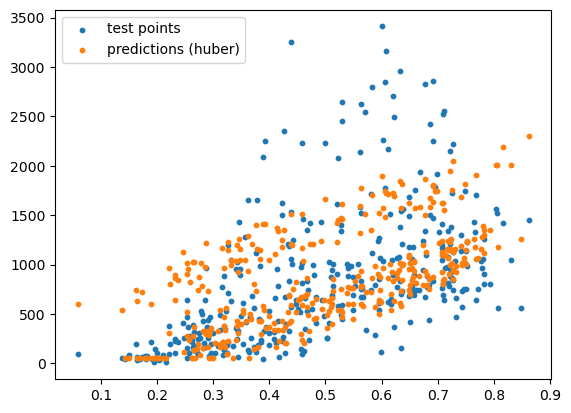

In [12]:
# (C) Plot best model
temp_te = X_te[:, 0]  # 0: temperatures column
plt.scatter(temp_te, y_te, s=10, label="test points")
plt.scatter(temp_te, y_pred_huber, s=10, label="predictions (huber)")
plt.legend()
plt.show()

Exercise - Separate sources and fit two linear regressions
---

We saw in the course that we can identify two sources in the data.

1. Data points collected during working days
1. Data points collected during non-working days

The goal of this exercise is to create a model for each source and see whether this improves performance.

> **Exercise**: Create a model for each source and evaluate the overall performance on the test set using MAE. Compare your models to a baseline using a bar chart.

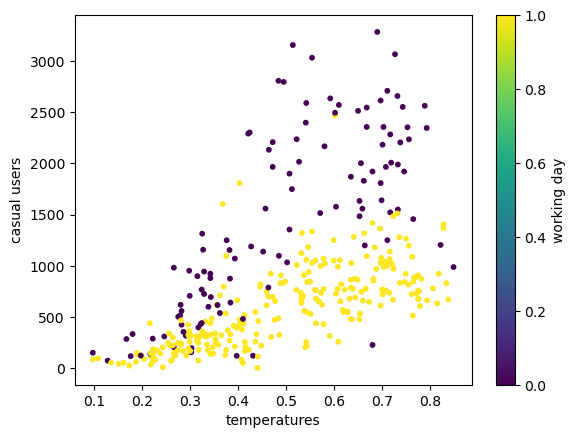

In [13]:
# We can identify two sources
temp_tr = X_tr[:, 0]  # 0: temp column
wd_tr = X_tr[:, 4]  # 4: workingday column

plt.scatter(temp_tr, y_tr, c=wd_tr, s=10)
plt.colorbar(label="working day")
plt.xlabel("temperatures")
plt.ylabel("casual users")
plt.show()

In [14]:
# Separate data points from the two sources
# * wd: working day
# * nwd: non-working day
columns = [0, 1, 2, 3, 5]  # Also, remove column 4: workingday

# Train set
wd_idx_tr = X_tr[:, 4] == 1  # Entries with workingday == 1

X_tr_wd = X_tr[wd_idx_tr][:, columns]
y_tr_wd = y_tr[wd_idx_tr]

X_tr_nwd = X_tr[~wd_idx_tr][:, columns]
y_tr_nwd = y_tr[~wd_idx_tr]

# Test set
wd_idx_te = X_te[:, 4] == 1  # Entries with workingday == 1

X_te_wd = X_te[wd_idx_te][:, columns]
y_te_wd = y_te[wd_idx_te]

X_te_nwd = X_te[~wd_idx_te][:, columns]
y_te_nwd = y_te[~wd_idx_te]



MAE linear regression: 246.269


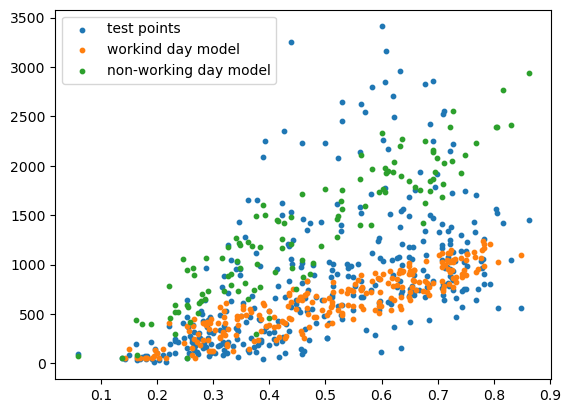

In [15]:
# Linear regression
lr_wd = LinearRegression()  # Model for working days
lr_nwd = LinearRegression()  # Model for non-working days

lr_wd.fit(X_tr_wd, y_tr_wd)  # Fit models to train data
lr_nwd.fit(X_tr_nwd, y_tr_nwd)

y_pred_lr_wd = np.maximum(
    lr_wd.predict(X_te_wd), 50  # Predictions for test data  # set a lower limit
)
y_pred_lr_nwd = np.maximum(
    lr_nwd.predict(X_te_nwd), 50  # Same for non-working days  # set a lower limit
)

# Reassemble test data and predictions
# target values
y_te_wdnwd = np.concatenate((y_te_wd, y_te_nwd))

# predictions
y_pred_lr_wdnwd = np.concatenate((y_pred_lr_wd, y_pred_lr_nwd))

# Compute MAE
mae_lr_wdnwd = MAE(y_te_wdnwd, y_pred_lr_wdnwd)
print("MAE linear regression: {:.3f}".format(mae_lr_wdnwd))

# Plot temperatures for working days and non-working days
temp_te_wdnwd = np.concatenate((X_te_wd[:, 0], X_te_nwd[:, 0]))
plt.scatter(temp_te_wdnwd, y_te_wdnwd, s=10, label="test points")

# Predictions for working days
plt.scatter(X_te_wd[:, 0], y_pred_lr_wd, s=10, label="workind day model")

# Predictions for non-working days
plt.scatter(X_te_nwd[:, 0], y_pred_lr_nwd, s=10, label="non-working day model")

plt.legend()
plt.show()

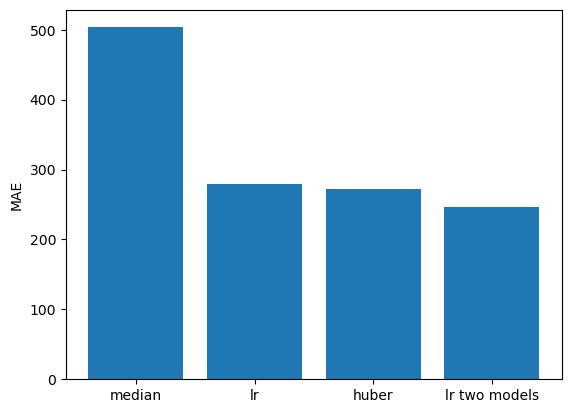

In [16]:
# Create baseline
mae_baseline = MAE(y_te, np.median(y_tr))

# Final comparison
mae_values = [mae_baseline, mae_lr, mae_huber, mae_lr_wdnwd]
titles = ["median", "lr", "huber", "lr two models"]

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel("MAE")
plt.show()

Exercise - R^2 coefficient
---

> **Exercise**: Compute the $R^{2}$ coefficient of your different models on the test set.

In [17]:
# R2 coefficients
r2_lr = lr.score(X_te, y_te)
r2_huber = huber.score(X_te, y_te)

print("R^2 linear regression:", r2_lr)
print("R^2 huber loss:", r2_huber)

# R2 coefficient when separating sources
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))


rss_lr_wdnwd = RSS(y_te_wdnwd, y_pred_lr_wdnwd)
rss_baseline = RSS(y_te, y_te.mean())
r2_lr_wdnwd = 1 - rss_lr_wdnwd / rss_baseline

print("R^2 when separating sources:", r2_lr_wdnwd)

R^2 linear regression: 0.6680357017933192
R^2 huber loss: 0.667148361920527
R^2 when separating sources: 0.7250821656146723
